In [319]:
import numpy as np
import pandas as pd

import os, sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

import math
from sklearn.cluster import KMeans

import statsmodels.stats as sm_stats

In [320]:
BASEPATH = "data"

files = os.listdir(BASEPATH)

# Load Data

In [321]:
df_sample = pd.read_csv(os.path.join(BASEPATH, "Gat201_samplesheet.csv"))
df_counts = pd.read_csv(os.path.join(BASEPATH, "counts_all.csv"))

In [322]:
df_k = {}
for k in [2,3,4,5]:
    if k == 5:
        df_k[k] = pd.read_csv(os.path.join(BASEPATH, f"H99_all_genes_promoter_500nt_{k}mer_counts.csv"))
    else:
        df_k[k] = pd.read_csv(os.path.join(BASEPATH, f"H99_all_genes_promoter_500nt_{k}mer_counts.csv"), skiprows=10)

## Statistics

In [335]:
df_sample.describe()

,Timepoint,Time,BioRep
count,56.000000,56.000000,56.000000
mean,111.428571,111.428571,1.500000
std,92.548338,92.548338,0.504525
min,0.000000,0.000000,1.000000
25%,30.000000,30.000000,1.000000
50%,120.000000,120.000000,1.500000
75%,240.000000,240.000000,2.000000
max,240.000000,240.000000,2.000000


In [334]:
df_counts.describe()

,Chr,Start,End,Length,A_Y_0_1,A_R_30_1,A_R_120_1,A_R_240_1,A_Y_0_2,A_R_30_2,...,M_Y_0_2,M_R_30_2,M_R_120_2,M_R_240_2,M_RS_30_1,M_RS_120_1,M_RS_240_1,M_RS_30_2,M_RS_120_2,M_RS_240_2
count,6795.000000,6.795000e+03,6.795000e+03,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,...,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000
mean,6.482119,7.361047e+05,7.384100e+05,2306.298308,743.840618,550.676821,677.230169,567.639294,234.429139,550.139073,...,673.214128,476.425018,1025.163355,1262.574982,1317.333628,1068.108904,857.004562,1071.700221,579.619132,983.515820
std,3.949612,4.844725e+05,4.844749e+05,1319.101285,3816.413213,2727.057223,2373.760541,1689.799763,875.700547,2246.151670,...,3523.571623,2322.497647,3787.069614,3968.380745,7528.339902,4313.387571,3765.505437,6278.894863,2194.404878,3269.405985
min,1.000000,2.000000e+01,5.000000e+02,147.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.439850e+05,3.472035e+05,1386.000000,107.000000,45.000000,115.000000,101.000000,34.000000,49.000000,...,95.000000,37.000000,179.000000,209.000000,91.000000,164.000000,122.000000,72.000000,88.000000,151.000000
50%,6.000000,6.755880e+05,6.776900e+05,2009.000000,253.000000,135.000000,251.000000,224.000000,81.000000,149.000000,...,231.000000,114.000000,384.000000,468.000000,305.000000,367.000000,281.000000,230.000000,203.000000,348.000000
75%,10.000000,1.067093e+06,1.069793e+06,2879.000000,613.000000,379.000000,502.500000,452.000000,200.000000,415.500000,...,552.000000,345.000000,745.500000,957.000000,896.000000,745.000000,583.000000,706.000000,426.000000,721.000000
max,14.000000,2.285051e+06,2.286491e+06,15963.000000,275529.000000,165146.000000,73112.000000,53639.000000,47375.000000,125169.000000,...,254044.000000,149644.000000,126911.000000,106271.000000,501184.000000,179890.000000,177401.000000,419866.000000,81278.000000,101327.000000


# Zero Values

In [427]:
def format_number(value):
    if value >= 1_000_000:
        return f'{value/1_000_000:.1f}M'
    elif value >= 1_000:
        return f'{value/1_000:.1f}K'
    else:
        return f'{value:.2f}'
        
def viz_zeros_one(df, col, title="None",ylim=9_000, ylab='Frequency', ax=None):
    # Plot for zero_genid
    if ax:
        ax1 = df[[col]].plot.bar(ax=ax)
    else:
        ax1 = df[[col]].plot.bar(figsize=(3,5))
        
    ax1.set_title(title)
    ax1.set_ylim(0, ylim)  # Adjust y-axis limits as needed
    ax1.set_xlabel('K-mers')
    ax1.set_ylabel(ylab)
    # Add labels on top of each bar
    for p in ax1.patches:
        ax1.annotate(format_number(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.015))
    
    plt.show()

    
def viz_zeros(df_k, variant='None'):
    zero_data = []

    col_zero_val = 'Gene in Sample'
    col_zero_user = 'User'
    
    for k in [2,3,4,5]:
        vals = {'k':k,
                col_zero_val: np.where(df_k[k].values[:,1:]==0)[0].shape[0],
                col_zero_user: np.unique(np.where(df_k[k].values[:,1:]==0)[0]).shape[0],
               }
        zero_data.append(vals)
    # pd.DataFrame(zero_data).set_index('k')[['zero_genid']].plot.bar()
    # pd.DataFrame(zero_data).set_index('k')[['zero_val']].plot.bar()

    df = pd.DataFrame(zero_data).set_index('k')

    # Plot for zero_genid
    viz_zeros_one(df, col_zero_user, f'{col_zero_user} have zero value ({variant})', 10_000)
    
    # Plot for zero_val
    viz_zeros_one(df, col_zero_val, f'{col_zero_val} have zero value ({variant})', 7_000_000)

    return df

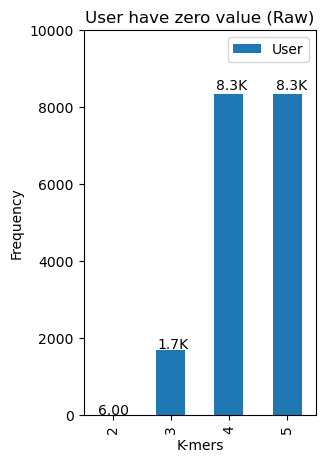

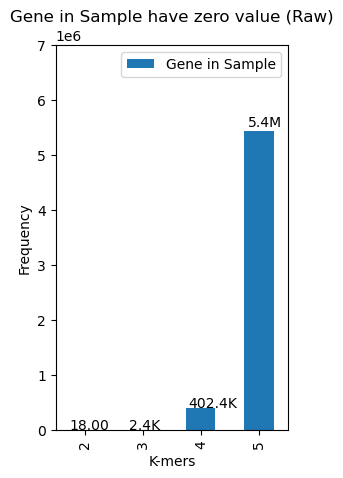

In [428]:
df_zero_pre = viz_zeros(df_k, 'Raw')

In [429]:
def gen_coding(x):
    if x == 'A':
        return 'T'
    elif x == "T":
        return 'A'
    elif x == 'C':
        return 'G'
    else:
        return 'C'
        
def gen_reverse_coding(x):
    y = list(x)
    y.reverse()
    y = [gen_coding(i) for i in y]
    return "".join(y)

### Unit test
gen_reverse_coding("ACTGG") == 'CCAGT'

def agg_comp_gene(df):
    agg_data = {}
    for col in df.columns[1:,]:
        col_pair = gen_reverse_coding(col)
        if (col not in agg_data) and (col_pair not in agg_data):
            if col == col_pair:
                agg_data[col] = df[col].values
            else:
                agg_data[col] = df[col].values + df[col_pair].values
    return pd.DataFrame(agg_data, index=df['Gene']).reset_index()

In [430]:
df_kc = {}
for k in [2,3,4,5]:
    df_kc[k] = agg_comp_gene(df_k[k])

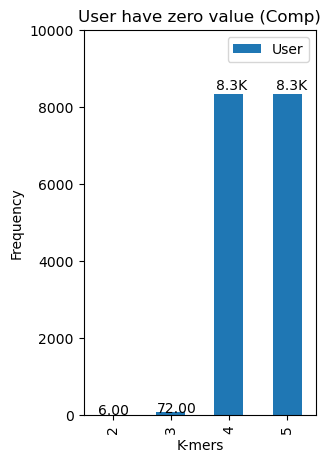

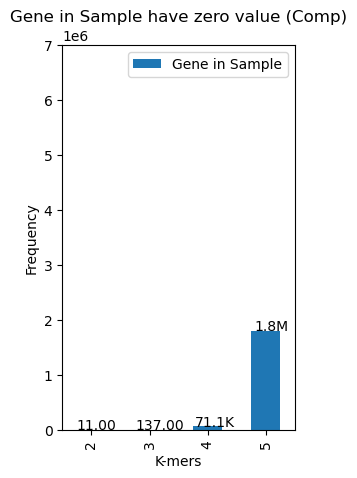

In [431]:
df_zero_post = viz_zeros(df_kc, 'Comp')

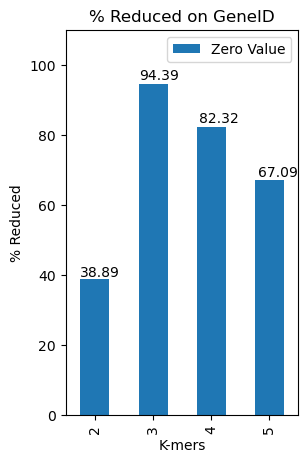

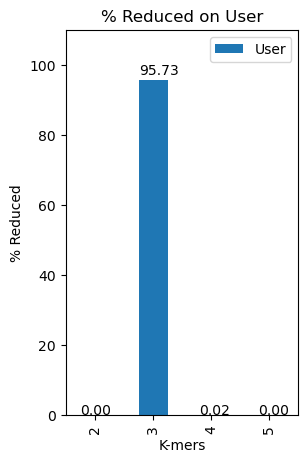

In [423]:
df_zero_gap_perc = (df_zero_pre  - df_zero_post)/df_zero_pre*100

viz_zeros_one(df_zero_gap_perc, 'Zero Value', "% Reduced on GeneID", 110, ylab='% Reduced')
viz_zeros_one(df_zero_gap_perc, 'User', "% Reduced on User", 110, ylab='% Reduced')


In [392]:
[df_kc[i].set_index('Gene').columns.shape[0] for i in [2,3,4,5]]

[10, 32, 136, 512]

In [393]:
np.sum([df_kc[i].set_index('Gene').columns.shape[0] for i in [2,3,4,5]])

690

## Feature Engineering: Build the dataset

In [329]:
# Get temporary dataset
dval = df_counts[df_sample['Title'].values]

# Reshape the data to be long
df_main = pd.DataFrame(data={
    'geneid':np.concatenate([df_counts['Geneid'].values]*dval.shape[1]),
    'title': np.repeat(df_sample['Title'].values, dval.shape[0]),
    'count': np.concatenate(dval.T.values)
    
})

# Get the factors from title
df_main['strain'] = df_main['title'].apply(lambda x: x.split('_')[0])
df_main['media'] = df_main['title'].apply(lambda x: x.split('_')[1])
df_main['time'] = df_main['title'].apply(lambda x: x.split('_')[2])
df_main['replica'] = df_main['title'].apply(lambda x: x.split('_')[3])

df_main['genotype'] = df_main['strain'].apply(lambda x: 'WT' if x in ['A', 'a'] else 'del')
df_main['count'] += 1

df_main_median_normalizer = np.log(df_main[['title', 'count']].groupby('title').median()).reset_index()
df_main_median_normalizer = df_main_median_normalizer.rename(columns={'count': 'count_log_med'})


In [330]:
df_sample.head(3)

,SampleID,Title,Group,Strain,GAT201,Media,Condition,Timepoint,Time,BioRep
0,1,A_Y_0_1,A_Y_0,A,WT,YPD,Y,0,0,1
1,2,A_R_30_1,A_R_30,A,WT,RPMI,R,30,30,1
2,3,A_R_120_1,A_R_120,A,WT,RPMI,R,120,120,1


In [331]:
df_main_log = df_main.copy()
df_main_log = pd.merge(df_main_log, df_main_median_normalizer, on='title', how='left')
df_main_log['count'] = np.log(df_main_log['count']+1) - df_main_log['count_log_med']


In [14]:
df_main_log.head(2)

,geneid,title,count,strain,media,time,replica,genotype,count_log_med
0,CNAG_00002,A_Y_0_1,0.498147,A,Y,0,1,WT,5.537334
1,CNAG_00003,A_Y_0_1,0.531091,A,Y,0,1,WT,5.537334


In [15]:
# output overview
df_main.head(2)

,geneid,title,count,strain,media,time,replica,genotype
0,CNAG_00002,A_Y_0_1,417,A,Y,0,1,WT
1,CNAG_00003,A_Y_0_1,431,A,Y,0,1,WT


### Statistical Analysis on Factors

In [432]:
def viz_boxplot_count(df_main, col, variant):
    # Create the boxplot grouped by 'strain'
    ax = df_main.boxplot(column='count', by=col, grid=False)
    
    # Set the title, x label, and y label
    plt.suptitle('')  # Suppress the default title to set a custom one
    plt.title(f'Boxplot by {col} - {variant}')
    plt.xlabel(col)
    plt.ylabel('Count')
    
    # Calculate and annotate the number of outliers
    for i, strain in enumerate(df_main[col].unique()):
        strain_data = df_main[df_main[col] == strain]['count']
        q1 = strain_data.quantile(0.25)
        q3 = strain_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = strain_data[(strain_data < lower_bound) | (strain_data > upper_bound)]
        num_outliers = outliers.shape[0]
        
        # Annotate number of outliers
        ax.text(i + 1.2, upper_bound, f'Outliers: {num_outliers}', ha='center', va='bottom', fontsize=10, rotation=90)
    
    # Show the plot
    plt.show()

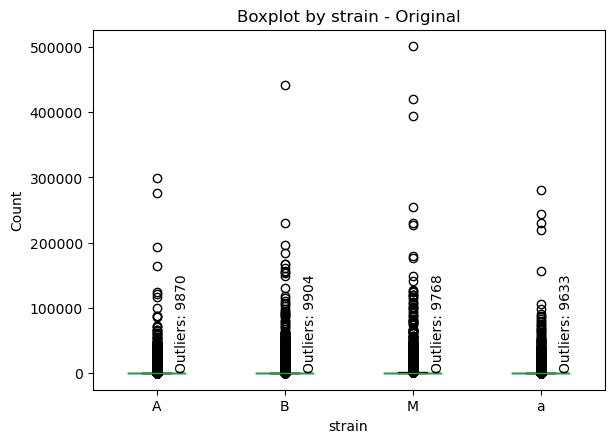

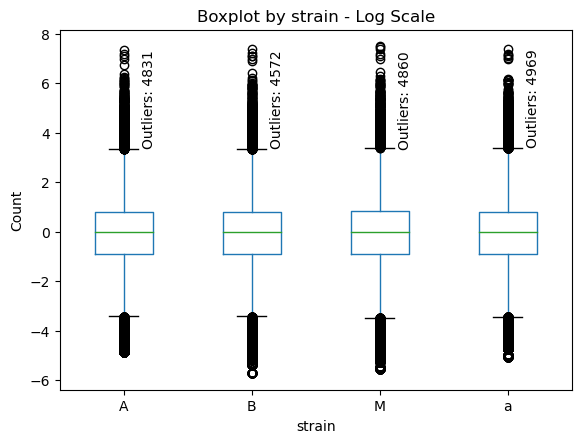

In [433]:

viz_boxplot_count(df_main, col='strain', variant="Original")
viz_boxplot_count(df_main_log, col='strain', variant="Log Scale")

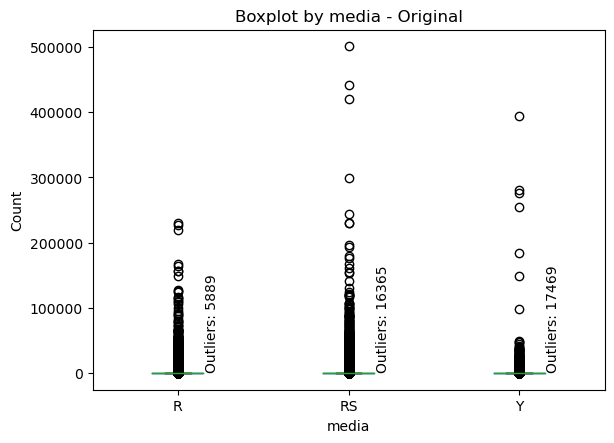

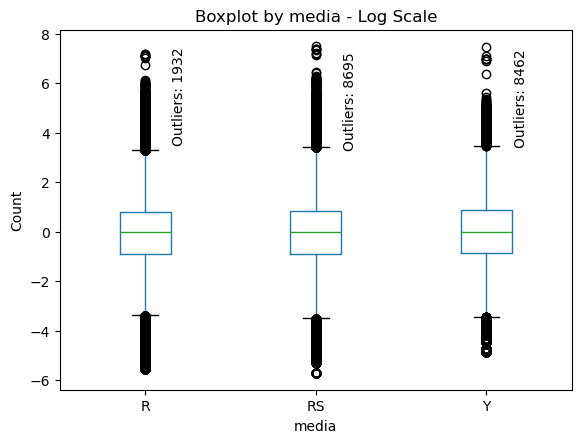

In [434]:
viz_boxplot_count(df_main, col='media', variant="Original")
viz_boxplot_count(df_main_log, col='media', variant="Log Scale")

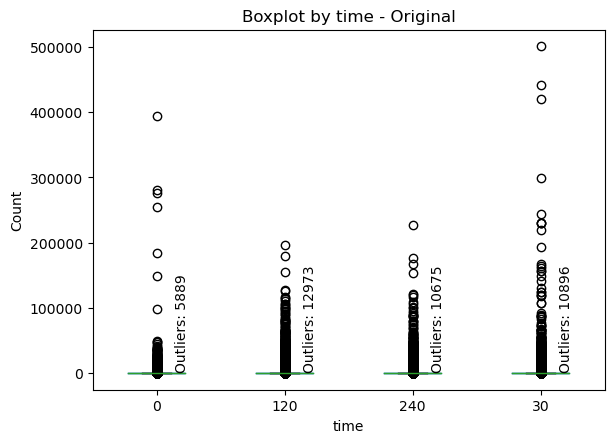

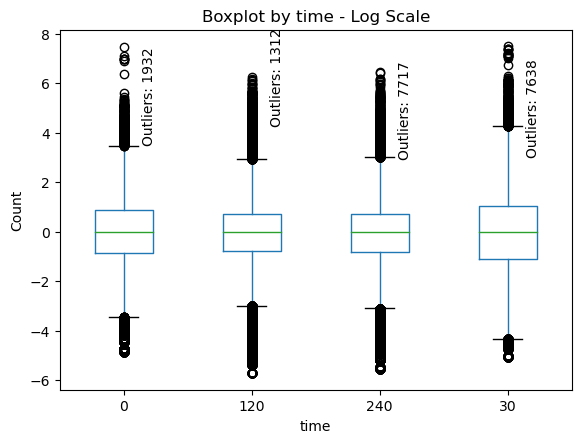

In [435]:
viz_boxplot_count(df_main, col='time', variant="Original")
viz_boxplot_count(df_main_log, col='time', variant="Log Scale")

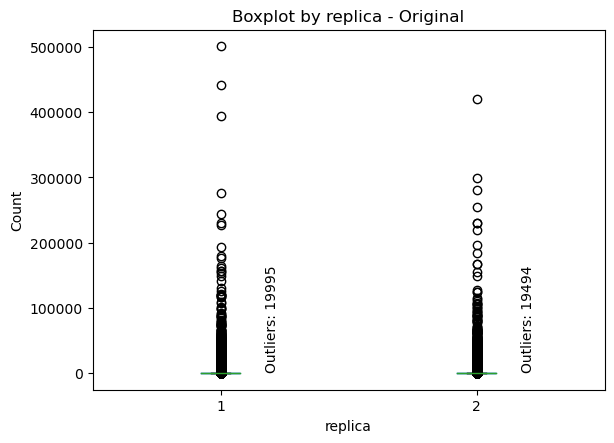

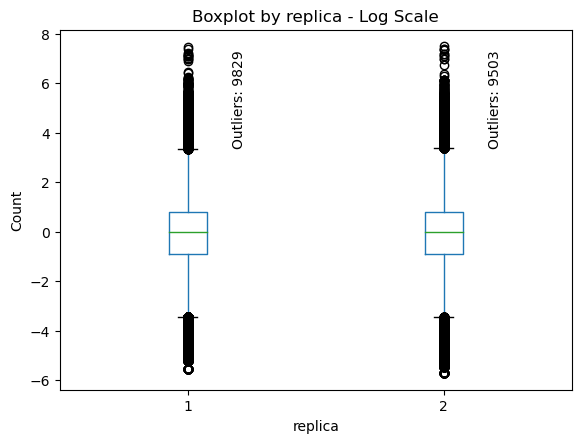

In [436]:
viz_boxplot_count(df_main, col='replica', variant="Original")
viz_boxplot_count(df_main_log, col='replica', variant="Log Scale")

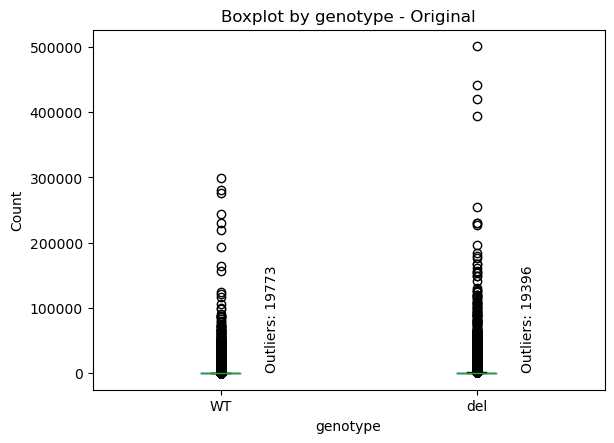

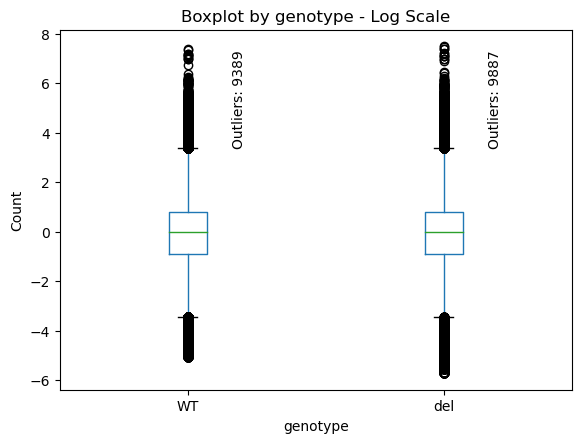

In [437]:
viz_boxplot_count(df_main, col='genotype', variant="Original")
viz_boxplot_count(df_main_log, col='genotype', variant="Log Scale")

In [438]:
def viz_bygroup_count(df_main, col):
    # Get the unique group
    groups = df_main[col].unique()
    n = len(groups)
    
    # Calculate the number of rows needed
    n_rows = math.ceil(n / 2)
    
    # Create subplots with n/2 rows and 2 columns
    fig, axes = plt.subplots(n_rows, 2, figsize=(6, 2 * n_rows), sharex=True, sharey=True)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Create a histogram for each Group
    for ax, g in zip(axes, groups):
        df_main[df_main[col] == g]['count'].plot.hist(bins=50, ax=ax)
        ax.set_title(f'Histogram for Group {g}')
        ax.set_xlabel('Count')
        ax.set_ylabel('Frequency')
    
    # Remove any unused subplots
    for ax in axes[n:]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()

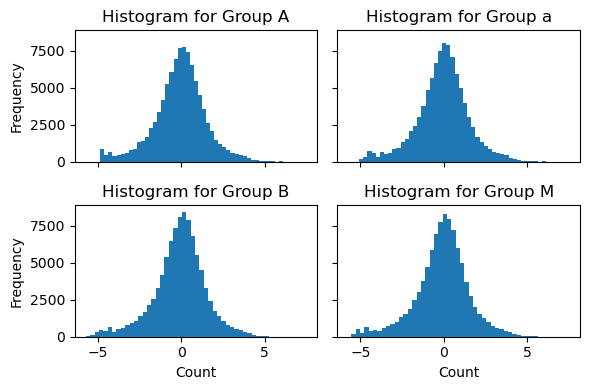

In [24]:
viz_bygroup_count(df_main_log, 'strain')

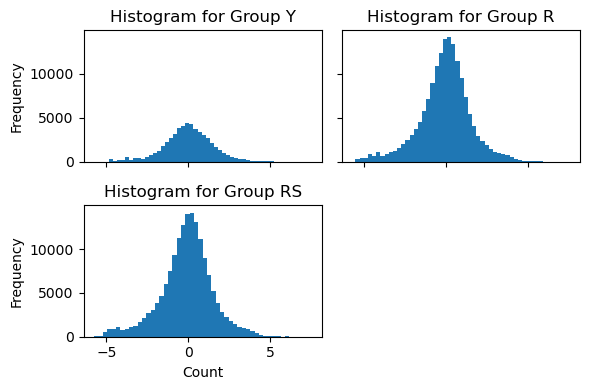

In [25]:
viz_bygroup_count(df_main_log, 'media')

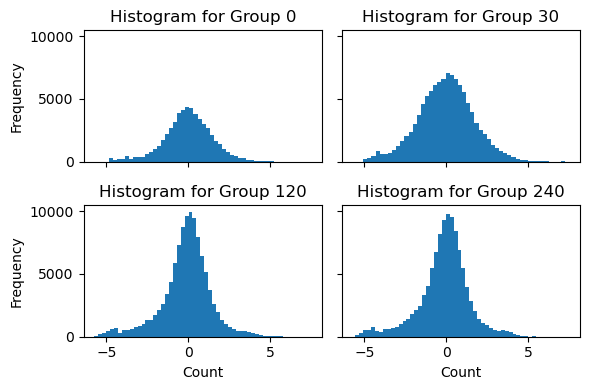

In [259]:
viz_bygroup_count(df_main_log, 'time')

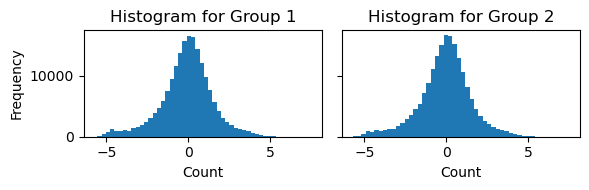

In [260]:
viz_bygroup_count(df_main_log, 'replica')

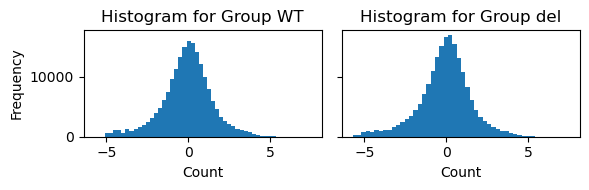

In [261]:
viz_bygroup_count(df_main_log, 'genotype')

In [26]:
def plot_data_summary(df_main_log, agg='mean', include_replica=True, is_one=None, is_logscale=False):
    # Plotting multiple lines
    fig, ax = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)

    max_y = None
    
    for s in ['A', 'a', 'B', 'M']:
        i1 = 0
        i2 = 0
        if s in ['a', 'M']:
            i1 += 1
        if s in ['B', 'M']:
            i2 += 1
    
        if s in ['B', 'M']:
            gtp = 'Del'
        else:
            gtp = 'WT'

        if include_replica:   
            df_one_strain = df_main_log[df_main_log['strain']==s].set_index('CNAG')
            if is_one:
                dd = df_one_strain[df_one_strain['geneid'] == is_one]
            
            dd = df_one_strain.groupby(['time', 'media', 'replica'])[['count']].apply(agg).reset_index()


            dd['time'] = dd['time'].astype(int)
            dd['replica'] = dd['replica'].astype(int)
            
            dd_pointR = dd[dd['media'].apply(lambda x: x in ['R', 'Y'])].sort_values('time', ascending=True)
            dd_pointY = dd[dd['media']=='Y'].sort_values('time', ascending=True)
            dd_pointRS = dd[dd['media'].apply(lambda x: x in ['RS', 'Y'])].sort_values('time', ascending=True)

            
             
            val_y_1 = dd_pointY[dd_pointY['replica']==1]['count']
            val_y_2 = dd_pointY[dd_pointY['replica']==2]['count']

            
            ax[i1][i2].scatter(x=0, y=val_y_1, c='r', label='Y')
            ax[i1][i2].scatter(x=0, y=val_y_2, c='r', label=None)
        
            ax[i1][i2].text(2, val_y_1 - 0.1,'Replica1')
            ax[i1][i2].text(2, val_y_2 + 0.1,'Replica2')
            
            df_rep_r_1 = dd_pointR[dd_pointR['replica']==1]
            df_rep_rs_1 = dd_pointRS[dd_pointRS['replica']==1]
            df_rep_r_2 = dd_pointR[dd_pointR['replica']==2]
            df_rep_rs_2 = dd_pointRS[dd_pointRS['replica']==2]

            
            
            ax[i1][i2].plot(df_rep_r_1['time'], df_rep_r_1['count'], label='R', color='#B8BBBE')  
            ax[i1][i2].plot(df_rep_rs_1['time'], df_rep_rs_1['count'], label='R+Serum', color='#C9190B')
                        
            
            ax[i1][i2].plot(df_rep_r_2['time'], df_rep_r_2['count'], label=None, color='#B8BBBE', linestyle=":")  
            ax[i1][i2].plot(df_rep_rs_2['time'], df_rep_rs_2['count'], label=None, color='#C9190B', linestyle=":")
        else:            
            df_one_strain = df_main_log[df_main_log['strain']==s].set_index('CNAG')
            
            if is_one:
                df_one_strain = df_one_strain[df_one_strain['geneid'] == is_one]
     
            dd = df_one_strain.groupby(['time', 'media'])[['count']].apply(agg).reset_index()

            dd_std = df_one_strain.groupby(['time', 'media', 'replica'])[['count']].apply(lambda x: np.std(x)).reset_index()

            dd['ub_1sd'] = dd['count'] + (dd_std['count']*1)
            dd['lb_1sd'] = dd['count'] - (dd_std['count']*1)
            
            dd['time'] = dd['time'].astype(int)
            dd_pointY = dd[dd['media']=='Y'].sort_values('time', ascending=True)
            dd_pointR = dd[dd['media'].apply(lambda x: x in ['R', 'Y'])].sort_values('time', ascending=True)
            dd_pointRS = dd[dd['media'].apply(lambda x: x in ['RS', 'Y'])].sort_values('time', ascending=True)
            
            val_y = dd_pointY['count']
            
            ax[i1][i2].scatter(x=0, y=val_y, c='r', label='Y')
            
            ax[i1][i2].plot(dd_pointR['time'], dd_pointR['count'], label='R', color='#B8BBBE')
            ax[i1][i2].plot(dd_pointR['time'], dd_pointR['ub_1sd'], label=None, color='#B8BBBE', linestyle=':')
            ax[i1][i2].plot(dd_pointR['time'], dd_pointR['lb_1sd'], label=None, color='#B8BBBE',  linestyle=':')
            ax[i1][i2].plot(dd_pointRS['time'], dd_pointRS['count'], label='R+Serum', color='#C9190B')
            ax[i1][i2].plot(dd_pointRS['time'], dd_pointRS['ub_1sd'], label=None, color='#C9190B',  linestyle=':')
            ax[i1][i2].plot(dd_pointRS['time'], dd_pointRS['lb_1sd'], label=None, color='#C9190B',  linestyle=':')

            if not max_y:
                max_y = max(dd['ub_1sd'])+0.1

            
        
            
        # # Set specific x-axis ticks
        ax[i1, i2].set_xticks([0, 30, 120, 240])
        ax[i1, i2].set_xlim([-10, 250])
        if is_logscale:
            ax[i1, i2].set_ylim([-2.5, 2.5])
        else:
            ax[i1, i2].set_ylim([-6000, 6000])
        if is_one:
            ax[i1, i2].set_title(f'({agg}) Behavior in strain {gtp}-{s}: {is_one}')
        else:
            ax[i1, i2].set_title(f'({agg}) Behavior in strain {gtp}-{s}')
    
        
        ax[i1, i2].set_xlabel('Time')
        ax[i1, i2].set_ylabel('Log(Count)')

    if (not is_one) and (not include_replica):
        ax[0][0].text(2, max_y,'1 Std. Dev. (68%)')
    ax[0,0].legend()
    plt.show()

In [27]:
df_main_log['CNAG'] = df_main_log['geneid'].apply(lambda x: int(x.split("_")[1]))
df_main['CNAG'] = df_main['geneid'].apply(lambda x: int(x.split("_")[1]))

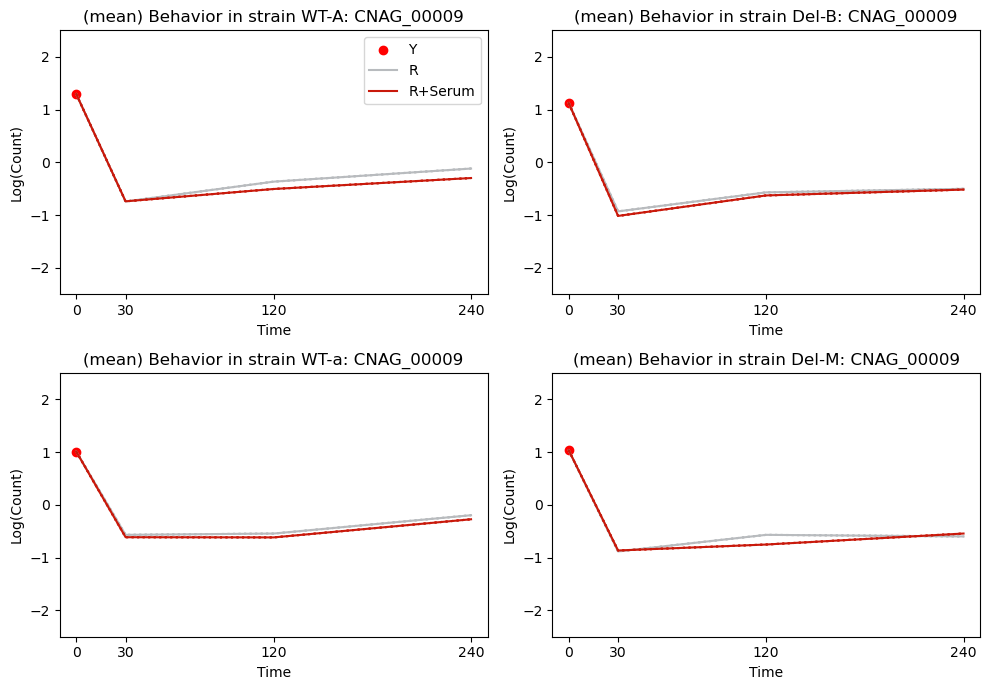

In [28]:
# Individual Plot (one gene)
plot_data_summary(df_main_log, agg='mean', include_replica=False, is_one='CNAG_00009', is_logscale=True)

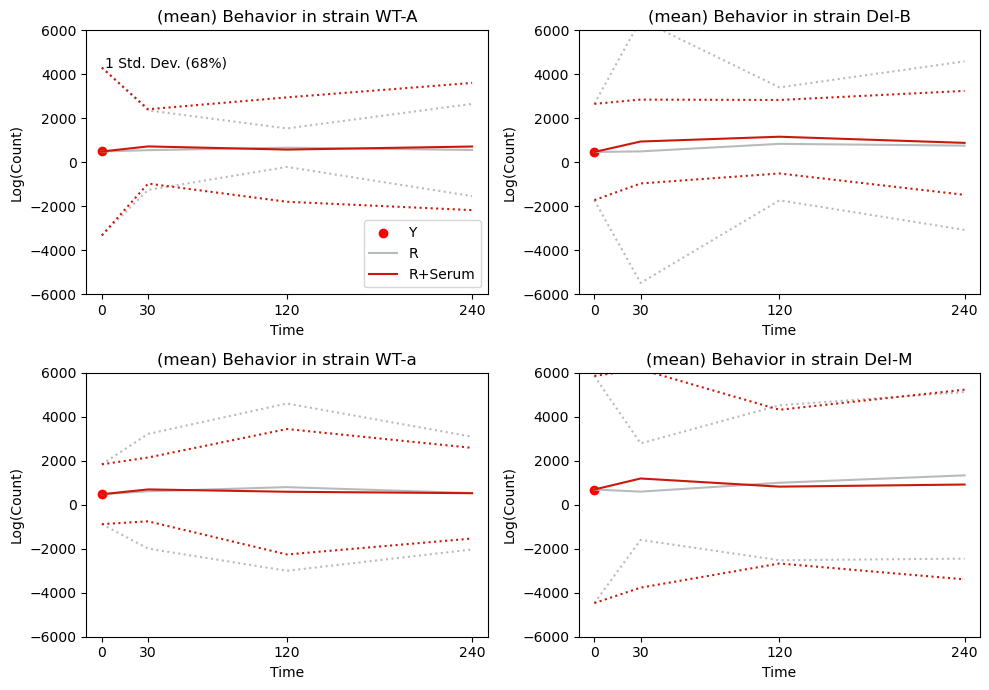

In [29]:
# Aggregate plot (all genes) Un-normalized
plot_data_summary(df_main, agg='mean', include_replica=False, is_logscale=False)

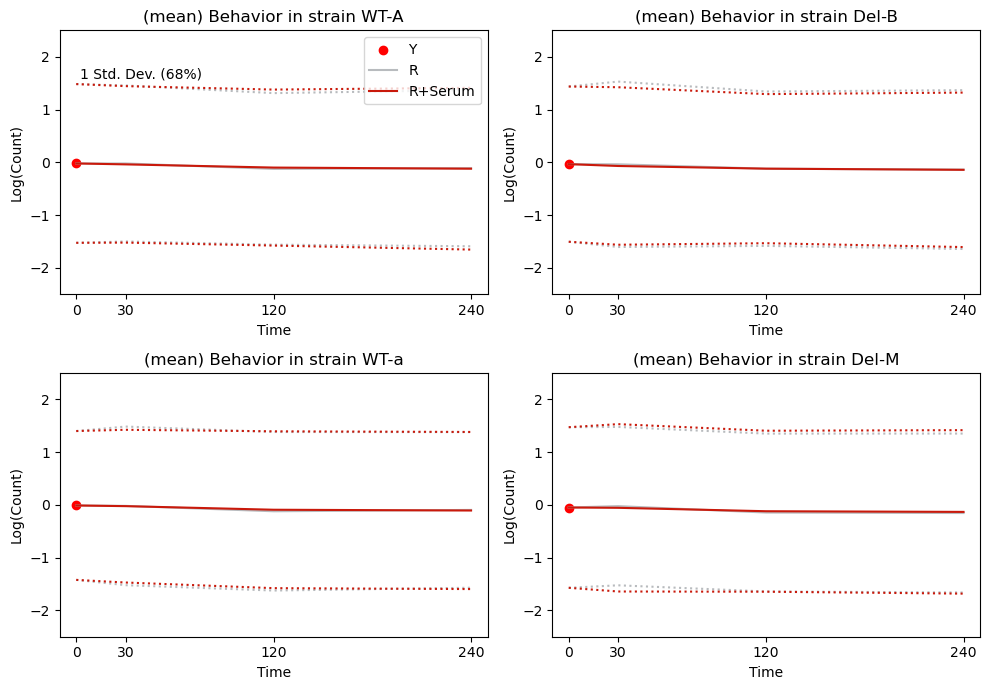

In [30]:
# Aggregate plot (all genes) - Normalized
plot_data_summary(df_main_log, agg='mean', include_replica=False, is_logscale=True)

/Users/alim/miniconda3/envs/main/lib/python3.11/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/Users/alim/miniconda3/envs/main/lib/python3.11/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


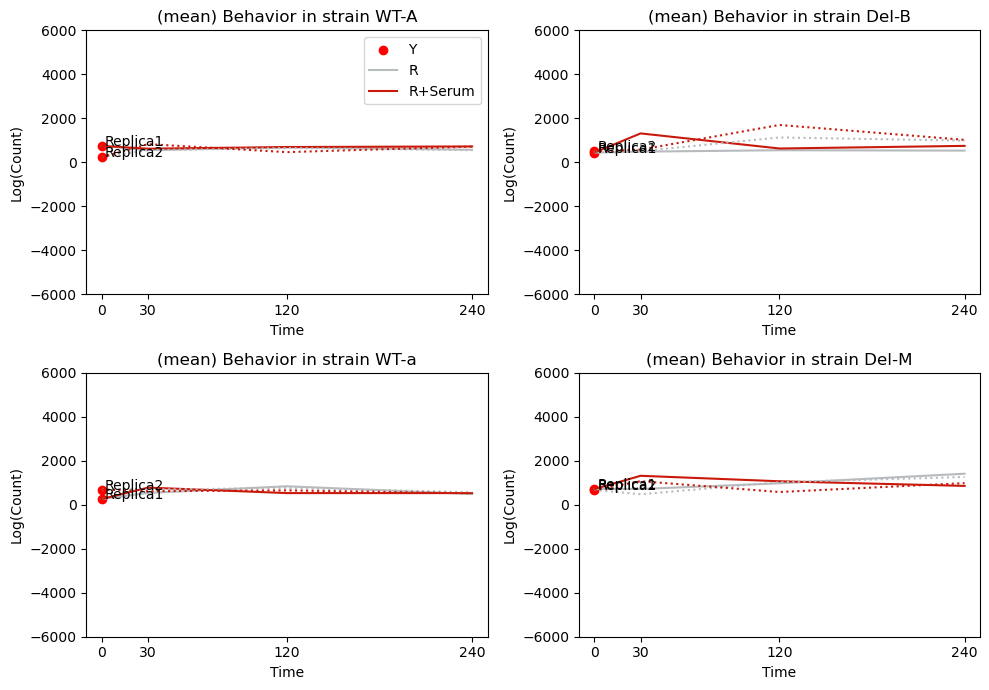

In [31]:
plot_data_summary(df_main, agg='mean', include_replica=True)

/Users/alim/miniconda3/envs/main/lib/python3.11/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/Users/alim/miniconda3/envs/main/lib/python3.11/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


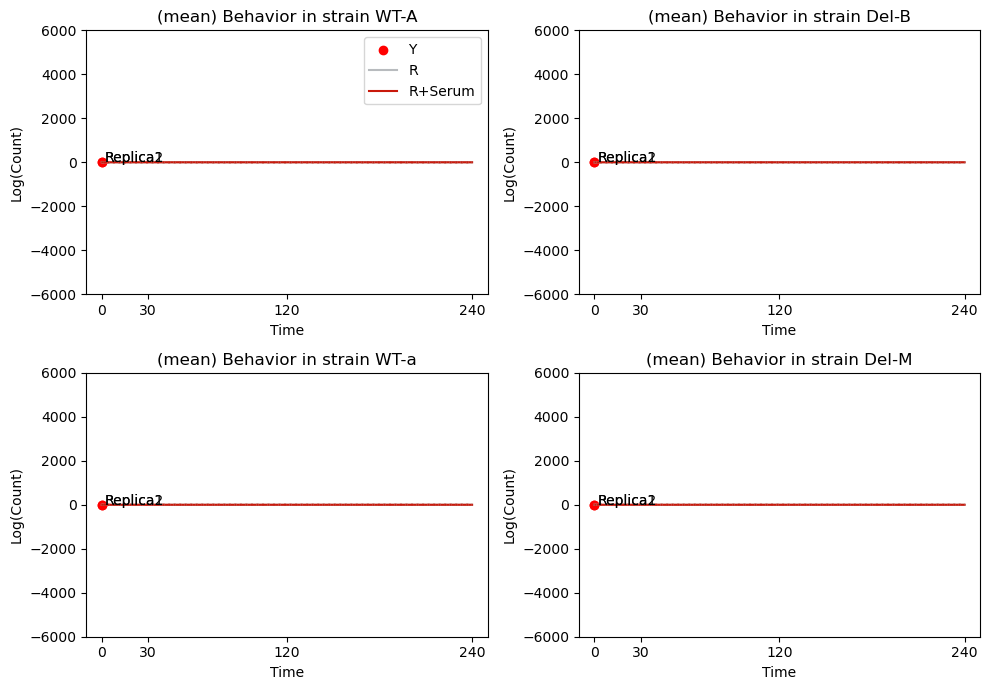

In [32]:
plot_data_summary(df_main_log, agg='mean', include_replica=True)

#### Findings:
1. Neglecting the replica condition, with serum always increase the count in t=30
2. Replica 1 & 2 has different Serum effect at time=120 only in Del
3. Replica 1 & 2 has different starter (Y, time-0) in WT, but not in Del

In [196]:
import scipy.stats as stats
def ks_test(data1, data2, alpha=0.05):
    """
    Perform the Kolmogorov-Smirnov test to compare two distributions.
    """
    statistic, p_value = stats.ks_2samp(data1, data2)
    
    is_significant = p_value < alpha
    return statistic, p_value, is_significant

# KS Test for the factors

## Strain

In [260]:
# Strain A and strain a are unable to reject null hypothesis.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['strain']=='A'][['count']].values[:,0], 
        df_main_log[df_main_log['strain']=='a'][['count']].values[:,0]
       )

(0.004614737727320508, 0.2623504284775455, False)

In [261]:
# Strain M and strain B are unable to reject null hypothesis.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['strain']=='M'][['count']].values[:,0], 
        df_main_log[df_main_log['strain']=='B'][['count']].values[:,0]
       )

(0.005445180279617367, 0.11868280701296519, False)

In [262]:
# Strain A and strain B are unable to reject null hypothesis.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['strain']=='A'][['count']].values[:,0], 
        df_main_log[df_main_log['strain']=='B'][['count']].values[:,0])

(0.0052244297277409864, 0.14848212465316657, False)

In [439]:
# Strain A and strain B are unable to reject null hypothesis.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['strain']=='A'][['count']].values[:,0], 
        df_main_log[df_main_log['strain']=='M'][['count']].values[:,0])

(0.009029748764848102, 0.0008506317133489695, True)

In [263]:
# Strain a and strain B CAN REJECT the NULL HYPOTHESIS.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['strain']=='a'][['count']].values[:,0], 
        df_main_log[df_main_log['strain']=='B'][['count']].values[:,0])

(0.006759171659833904, 0.025796090489944357, True)

In [264]:
# Strain a and strain M CAN REJECT the NULL HYPOTHESIS.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['strain']=='a'][['count']].values[:,0], 
        df_main_log[df_main_log['strain']=='M'][['count']].values[:,0])

(0.01000735835172921, 0.00014472180234045221, True)

## Replica

In [265]:
# Replica 1 and Replica 2 are unable to reject null hypothesis.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['replica']=='1'][['count']].values[:,0], 
        df_main_log[df_main_log['replica']=='2'][['count']].values[:,0]
       )

(0.003179859140123975, 0.2905768187144153, False)

## Genotype

In [266]:
# Genotype WT and Genotype del are unable to reject null hypothesis.
# Null hypothesis: both are the same
ks_test(df_main_log[df_main_log['genotype']=='WT'][['count']].values[:,0], 
        df_main_log[df_main_log['genotype']=='del'][['count']].values[:,0]
       )

(0.006885314832334705, 0.00024086366758482267, True)

## Time

In [267]:
# TIME ARE SIGNFICANT
ks_test(df_main_log[df_main_log['time']=='0'][['count']].values[:,0], 
        df_main_log[df_main_log['time']=='30'][['count']].values[:,0]
       )

(0.05526122148638707, 1.240773711434438e-96, True)

In [268]:
ks_test(df_main_log[df_main_log['time']=='0'][['count']].values[:,0], 
        df_main_log[df_main_log['time']=='120'][['count']].values[:,0]
       )

(0.04782928623988225, 1.7433282177365764e-72, True)

In [269]:
ks_test(df_main_log[df_main_log['time']=='0'][['count']].values[:,0], 
        df_main_log[df_main_log['time']=='240'][['count']].values[:,0]
       )

(0.045686166298749, 3.603270214309952e-66, True)

In [270]:
ks_test(df_main_log[df_main_log['time']=='30'][['count']].values[:,0], 
        df_main_log[df_main_log['time']=='120'][['count']].values[:,0]
       )

(0.08378403237674759, 0.0, True)

In [271]:
ks_test(df_main_log[df_main_log['time']=='30'][['count']].values[:,0], 
        df_main_log[df_main_log['time']=='240'][['count']].values[:,0]
       )

(0.08157652685798378, 3.97471325e-315, True)

In [272]:
ks_test(df_main_log[df_main_log['time']=='120'][['count']].values[:,0], 
        df_main_log[df_main_log['time']=='240'][['count']].values[:,0]
       )

(0.008103384841795458, 0.001578291704035038, True)

## Media

In [273]:
ks_test(df_main_log[df_main_log['media']=='R'][['count']].values[:,0], 
        df_main_log[df_main_log['media']=='RS'][['count']].values[:,0]
       )

(0.009424822173166536, 1.0163077386578895e-06, True)

## Time & Genotype

In [274]:
ks_test(df_main_log[(df_main_log['time']=='0')& (df_main_log['genotype']=='WT')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='0')& (df_main_log['genotype']=='del')][['count']].values[:,0])

(0.009713024282560708, 0.15289165722119824, False)

In [275]:
ks_test(df_main_log[(df_main_log['time']=='30')& (df_main_log['genotype']=='WT')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='30')& (df_main_log['genotype']=='del')][['count']].values[:,0])

(0.011810154525386307, 0.0010107943088722695, True)

In [276]:
ks_test(df_main_log[(df_main_log['time']=='120')& (df_main_log['genotype']=='WT')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='120')& (df_main_log['genotype']=='del')][['count']].values[:,0])

(0.008038999264164827, 0.05929070749961873, False)

In [277]:
ks_test(df_main_log[(df_main_log['time']=='240')& (df_main_log['genotype']=='WT')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='240')& (df_main_log['genotype']=='del')][['count']].values[:,0])

(0.01309786607799853, 0.00017661380094041712, True)

## Time and Media

In [297]:
np.mean(df_main_log[(df_main_log['time']=='120')& (df_main_log['media']=='R')][['count']].values[:,0])

-0.12921538444673134

In [298]:
np.mean(df_main_log[(df_main_log['time']=='120')& (df_main_log['media']=='RS')][['count']].values[:,0])

-0.10929790108080652

In [285]:
ks_test(df_main_log[(df_main_log['time']=='30')& (df_main_log['media']=='R')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='30')& (df_main_log['media']=='RS')][['count']].values[:,0])

(0.015194996320824147, 7.007063035415178e-06, True)

In [286]:
ks_test(df_main_log[(df_main_log['time']=='120')& (df_main_log['media']=='R')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='120')& (df_main_log['media']=='RS')][['count']].values[:,0])

(0.018671817512877054, 1.1597104197576126e-08, True)

In [287]:
ks_test(df_main_log[(df_main_log['time']=='240')& (df_main_log['media']=='R')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='240')& (df_main_log['media']=='RS')][['count']].values[:,0])

(0.00678807947019866, 0.16255765264456834, False)

## Time, Genotype, and Media

In [281]:
ks_test(df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='WT') & (df_main_log['media']=='R')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='WT') & (df_main_log['media']=='RS')][['count']].values[:,0])

(0.014716703458425323, 0.0054971086939043755, True)

In [282]:
ks_test(df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='del') & (df_main_log['media']=='R')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='del') & (df_main_log['media']=='RS')][['count']].values[:,0])

(0.018506254598969832, 0.00017895181544317756, True)

In [283]:
ks_test(df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='WT') & (df_main_log['media']=='R')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='del') & (df_main_log['media']=='R')][['count']].values[:,0])

(0.011883738042678449, 0.042711357469088274, True)

In [284]:
ks_test(df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='WT') & (df_main_log['media']=='RS')][['count']].values[:,0],
       df_main_log[(df_main_log['time']=='30') & (df_main_log['genotype']=='del') & (df_main_log['media']=='RS')][['count']].values[:,0])

(0.01387049300956586, 0.010615774332269554, True)

#### Findings:
Replica 1 and 2 is insignificant. They both the same

## GeneID Analysis

In [39]:
df_counts['g_id'] = df_counts['Geneid'].apply(lambda x: int(x.split('_')[1]))
col_counts = df_counts.columns.difference(['Geneid', 'Chr', 'Start', 'Strand', 'Length', 'End'])
df_counts_data = df_counts[col_counts].set_index('g_id').T

In [40]:
df_counts_data.head(2)

g_id,2,3,4,5,6,7,8,9,10,11,...,8022,8023,8024,8025,8026,8027,8028,8029,14001,14002
A_RS_120_1,371,104,244,588,1081,416,365,129,580,67,...,310,49,371,357,103,294,94,96,1,48
A_RS_120_2,319,66,131,353,702,364,230,100,355,35,...,221,138,149,257,38,133,43,42,1,28


Text(0, 0.5, 'cumulative explained variance')

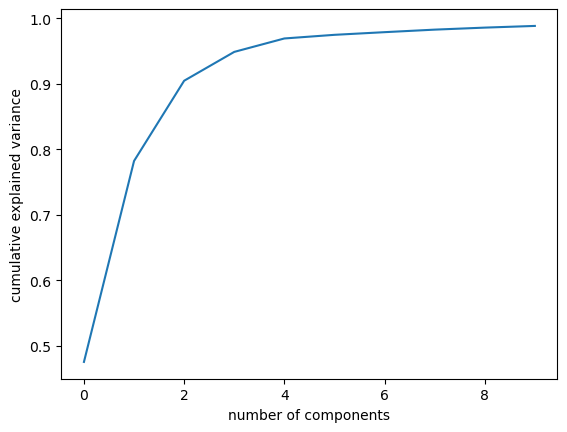

In [41]:
m_pca_cnt = PCA(10).fit(df_counts_data)

plt.plot(np.cumsum(m_pca_cnt.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


In [571]:
legend_dict = {
    'WT': '#ef5675',
    'del': '#ffa600',
    'A': 'r',
    'a': '#e06666',
    'B': 'b',
    'M': '#0098d4',
    'Y': '#7a5195',
    'R': '#ef5675',
    'RS': '#ffa600',
    '1' :'red',
    '2' :'blue',
    0: '^',
    30: '>',
    120: 'v',
    240: '<',
}

legend_dict_2 = {
    'color' : {
        'A': 'green',
        'a': 'green',
        'B': 'red',
        'M': 'red',
    },
    'time-size': {
        0: 10,
        30: 15,
        120: 30,
        240: 70
    },
    'shape': {
        'A': 'o',
        'a': 'x',
        'B': 'o',
        'M': 'x'
    },
    'serum-size': {
        'Y': 8,
        'R': 10,
        'RS': 50
    }
    
}

In [572]:
m_pca_cnt = PCA(4)
x_pca_cnt = m_pca_cnt.fit_transform(np.log(df_counts_data+1))



In [573]:
df_counts_data_pcs = pd.DataFrame(data=x_pca_cnt, index=df_counts_data.index).reset_index()

In [574]:
df_counts_data_pcs['strain'] = df_counts_data_pcs['index'].apply(lambda x: x.split('_')[0])
df_counts_data_pcs['media'] = df_counts_data_pcs['index'].apply(lambda x: x.split('_')[1])
df_counts_data_pcs['time'] = df_counts_data_pcs['index'].apply(lambda x: int(x.split('_')[2]))
df_counts_data_pcs['rep'] = df_counts_data_pcs['index'].apply(lambda x: x.split('_')[3])

df_counts_data_pcs['genotype'] = df_counts_data_pcs['strain'].apply(lambda x: 'WT' if x in ['A', 'a'] else 'del')

In [601]:
def vis_on_time(df, legend_dict, col='genotype', pc1=0, pc2=1):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot()

    if col=='time':
        clr = ["#003f5c", "#7a5195", "#ef5675", "#ffa600"]
        for idx, t in enumerate([0, 30, 120, 240]):
            idx_marker = np.where(df['time'].values==t)[0]
            df_temp = df.loc[idx_marker].copy()
            
            ax.scatter(df_temp[pc1], 
                       df_temp[pc2], 
                       c=clr[idx], 
                       marker=legend_dict.get(t),
                       label=f'time:{t}')
            plt.legend()
    else:
        for t in [0, 30, 120, 240]:
            idx_marker = np.where(df['time'].values==t)[0]
            df_temp = df.loc[idx_marker].copy()
            
            ax.scatter(df_temp[pc1], 
                       df_temp[pc2], 
                       c=[legend_dict.get(i) for i in df_temp[col]], 
                       marker='o')
    
        # Create custom legend handles
        # legend_handles = [Line2D([0], [0], marker=marker, color='w', label=f"time:{label}",
        #                          markerfacecolor='black', markersize=10) 
        #                   for label, marker in zip([0, 30, 120, 240], ["^", ">", "v", "<"])]
        if col == 'genotype':
            legend_handles = [Patch(color=color, label=label) for label, color in zip(['gen_WT', 'gen_Del'], ['#ef5675', '#ffa600'])]
    
        elif col == 'media':
            legend_handles = [Patch(color=color, label=label) for label, color in zip(['Y','R', 'RS'], ['#7a5195','#ef5675', '#ffa600'])]
        else:
            legend_handles = []
            
        # Add the legend
        ax.legend(handles=legend_handles)

    plt.xlabel(f'PC={pc1+1}')
    plt.ylabel(f'PC={pc2+1}')
    
    plt.title(f'PCA on Count Data - {col} ')
    
    # plt.legend()
    # plt.show()

In [602]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


In [603]:
from matplotlib import markers

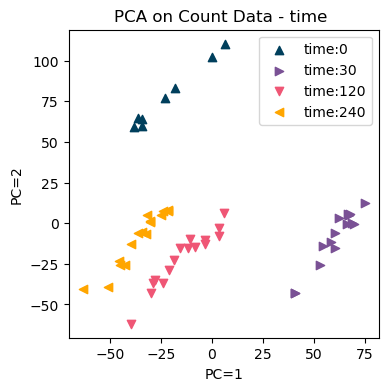

In [604]:
vis_on_time(df_counts_data_pcs, legend_dict, 'time', 0, 1)

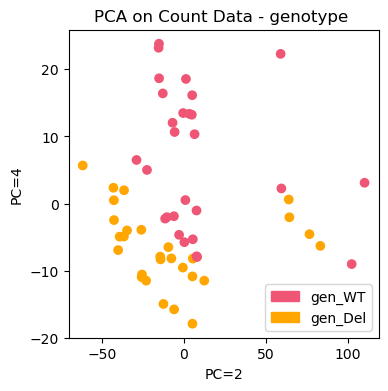

In [605]:
vis_on_time(df_counts_data_pcs, legend_dict, 'genotype', 1, 3)

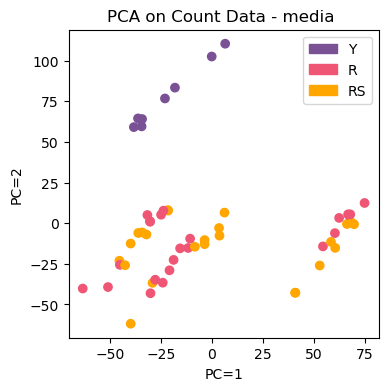

In [621]:
vis_on_time(df_counts_data_pcs, legend_dict, 'media', 0, 1)

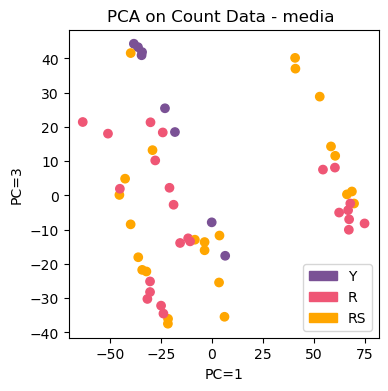

In [622]:
vis_on_time(df_counts_data_pcs, legend_dict, 'media', 0, 2)

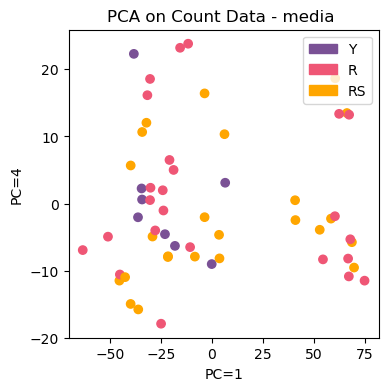

In [623]:
vis_on_time(df_counts_data_pcs, legend_dict, 'media', 0, 3)

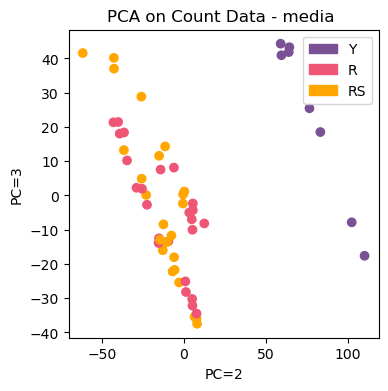

In [624]:
vis_on_time(df_counts_data_pcs, legend_dict, 'media', 1, 2)

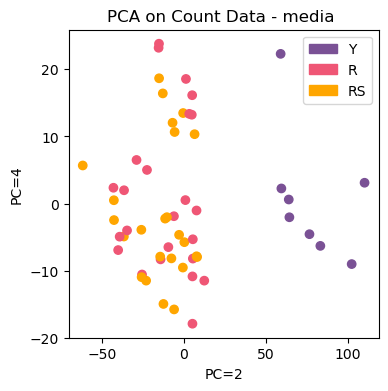

In [625]:
vis_on_time(df_counts_data_pcs, legend_dict, 'media', 1, 3)

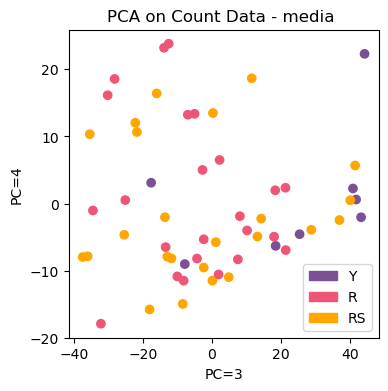

In [626]:
vis_on_time(df_counts_data_pcs, legend_dict, 'media', 2, 3)

## Clustering

In [650]:
inertia = []

# X_cols = df.columns.difference(['geneid', 'title', 'title', 'media', 'time', 'replica', 'genotype', 'count', 'Gene'])
NN=15
for n in range(1 , NN):
    model_kmeans = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    model_kmeans.fit(df_counts_data)
    inertia.append(model_kmeans.inertia_)

/Users/alim/miniconda3/envs/main/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(


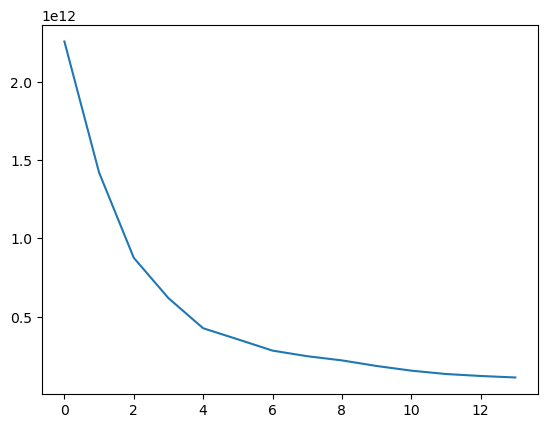

In [651]:
plt.plot(inertia)

In [ ]:
model_kmeans = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                    tol=0.0001,  random_state= 111  , algorithm='elkan') )
model_kmeans.fit(df_counts_data)

y_clusters = model_kmeans.predict(df_counts_data)

list_strain = [i.split('_')[0] for i in df_counts_data.index]
list_media = [i.split('_')[1] for i in df_counts_data.index]
list_time = [i.split('_')[2] for i in df_counts_data.index]
list_rep = [i.split('_')[3] for i in df_counts_data.index]

df_cluster = pd.DataFrame({'rep':list_rep, 
                           'cluster':y_clusters,
                           'strain': list_strain,
                           'media': list_media,
                           'time': list_time,
                           'title': df_counts_data.index
                          })



In [ ]:
df_cluster_grp = df_cluster.groupby(['rep', 'cluster']).size().unstack(fill_value=0)
df_cluster_grp.plot(kind='bar', stacked=True)

<Axes: xlabel='strain'>

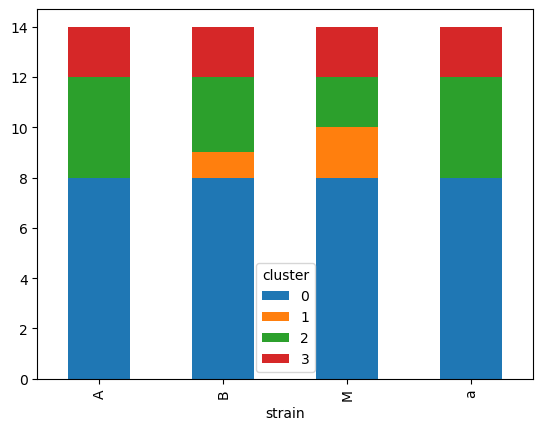

In [672]:
df_cluster_grp = df_cluster.groupby(['strain', 'cluster']).size().unstack(fill_value=0)
df_cluster_grp.plot(kind='bar', stacked=True)

<Axes: xlabel='media'>

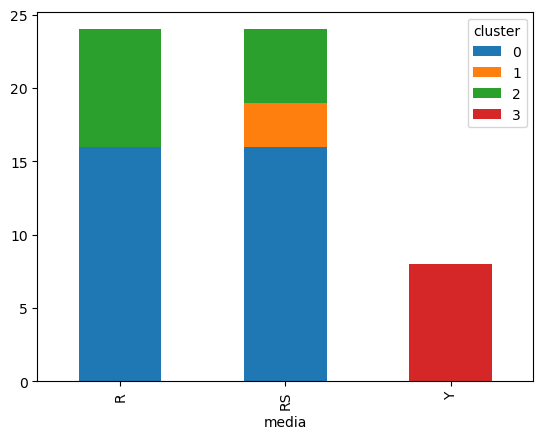

In [673]:
df_cluster_grp = df_cluster.groupby(['media', 'cluster']).size().unstack(fill_value=0)
df_cluster_grp.plot(kind='bar', stacked=True)

<Axes: xlabel='time'>

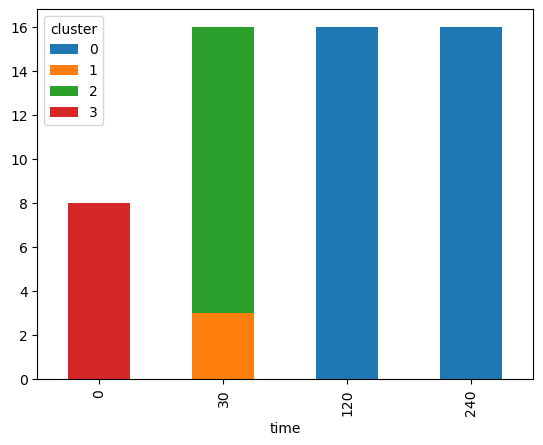

In [674]:
df_cluster_grp = df_cluster.groupby(['time', 'cluster']).size().unstack(fill_value=0)
df_cluster_grp.plot(kind='bar', stacked=True)

# Colinearity

In [675]:
def plot_corr_heatmap(data, method='pearson', annot=True, cmap='coolwarm'):
    """
    Generates a heatmap for the correlation matrix of a pandas DataFrame.

    Parameters:
    - data: pandas DataFrame containing the data
    - method: method for correlation calculation ('pearson', 'spearman', 'kendall')
    - annot: boolean, whether to annotate the cells with correlation values
    - cmap: color map to use for the heatmap

    Returns:
    - Heatmap plot
    """
    # Calculate the correlation matrix
    corr_matrix = data.corr(method=method)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(4, 4))
    
    # Draw the heatmap
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Add title
    plt.title(f'Correlation Heatmap ({method.capitalize()})', size=16)
    
    # Show the plot
    plt.show()

In [676]:
df_main_encoded_all = pd.get_dummies(df_main, columns=["media", "time", "genotype"], drop_first=False)
all_predictors = df_main_encoded_all.columns.difference(['geneid', 'title', 'count'])

df_main_encoded_all[all_predictors] = df_main_encoded_all[all_predictors]*1

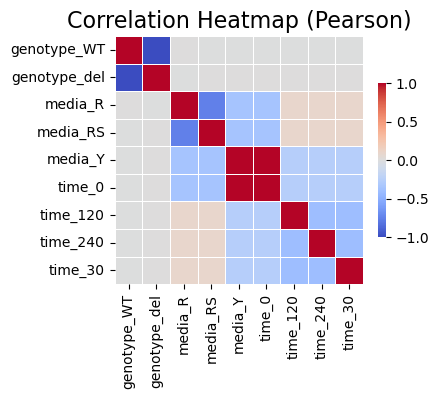

In [677]:
plot_corr_heatmap(df_main_encoded_all[all_predictors.difference(['replica', 'strain'])], annot=False)

## K-Mers Analysis

In [680]:
df_k[2].head(2)

,Gene,AA,CA,GA,TA,AC,CC,GC,TC,AG,CG,GG,TG,AT,CT,GT,TT
0,CNAG_01397,23,30,33,17,31,23,31,43,25,29,41,35,24,46,25,43
1,CNAG_06307,45,39,43,16,33,44,26,33,28,23,31,36,37,30,18,17


In [681]:
### Quick Analysis on gene without K-Mers

for k in df_k:
    no_kmers = [i for i in df_main_log['geneid'].unique() if i not in df_k[k]['Gene'].unique()]
    print(f"GeneID: {no_kmers}. They don't have k-mers in k={k}")


GeneID: ['CNAG_14001', 'CNAG_14002']. They don't have k-mers in k=2
GeneID: ['CNAG_14001', 'CNAG_14002']. They don't have k-mers in k=3
GeneID: ['CNAG_14001', 'CNAG_14002']. They don't have k-mers in k=4
GeneID: ['CNAG_14001', 'CNAG_14002']. They don't have k-mers in k=5


In [682]:
df_k_full = {}

for k in df_k:
    df_k_full[k] = pd.merge(df_k[k], 
                            df_main_log[['geneid', 'title', 'media', 'time', 'replica', 'genotype', 'count']],
                            how='inner',
                            left_on='Gene',
                            right_on='geneid'
                            )

In [683]:
def generate_pca(df_k_full, kmers):
    X_cols = df_k_full[kmers].columns.difference(['geneid', 'title', 'title', 'media', 'time', 'replica', 'genotype', 'count', 'Gene'])
    
    m_pca = {}
    x_pca = {}
    variances = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    
    if kmers >3:
        variances = [0.8]
    
    for i in variances:
        m_pca[i] = PCA(n_components=i)
        x_pca[i] = m_pca[i].fit_transform(df_k_full[kmers][X_cols])
    
    n_components = [m_pca[i].n_components_ for i in m_pca]    
    
    plt.figure(figsize=(6, 4))
    
    plt.bar(n_components, variances, width=0.9)
    plt.ylim(0, 1.19)
    plt.xlim(0, max(n_components))
    
    if max(n_components) > 20:
        cc = 1
    else:
        cc = 0
    for c,v in zip(n_components, variances):
        if v in [0.8, 0.85, 0.9, 0.95, 0.7]:
            plt.text(c+cc, v-0.2, f"{v}-{c}",rotation=90)
    return m_pca, x_pca

In [684]:
m_pca_all = {}
x_pca_all = {}

  0%|          | 0/4 [00:00<?, ?it/s]

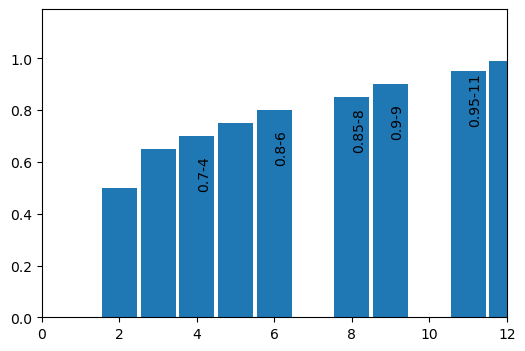

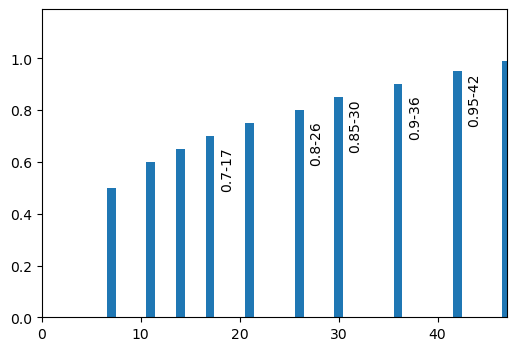

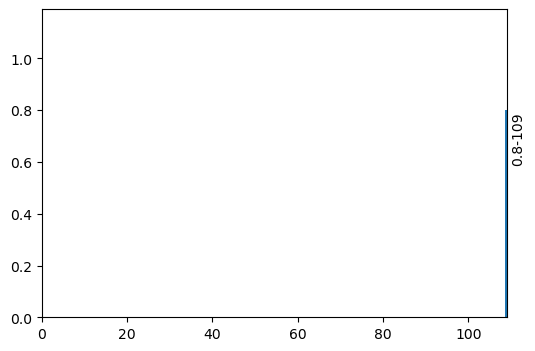

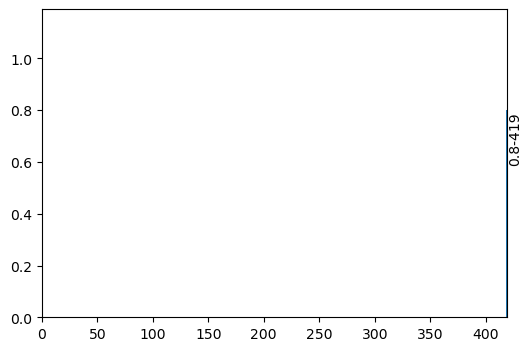

In [685]:
for k in tqdm([2,3,4,5]):
    m_pca_all[k], x_pca_all[k] = generate_pca(df_k_full, k)
    

In [686]:
def viz_heatmap_pca(m_pca, x_pca, v_target, kmers):
    df_k_full_pca = {}
    
    n_comps = m_pca[v_target].n_components_
    
    df_k_full_pca[kmers] = pd.merge(pd.DataFrame(x_pca[v_target]), 
             df_k_full[kmers][['media', 'time','replica', 'genotype', 'count']],
             left_index=True,
             right_index=True
            )
    
    corr_matrix = pd.get_dummies(df_k_full_pca[kmers], columns=['media', 'time', 'replica', 'genotype']).corr()
    y_cols = list(range(n_comps))
    x_cols = corr_matrix.columns.difference(y_cols)
    corr_matrix = corr_matrix.drop(x_cols)
    corr_matrix = corr_matrix.drop(y_cols, axis=1)
    plt.figure(figsize=(10, 5))
    sns.heatmap(corr_matrix, annot=False, fmt=".1f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix Heatmap')
    plt.show()


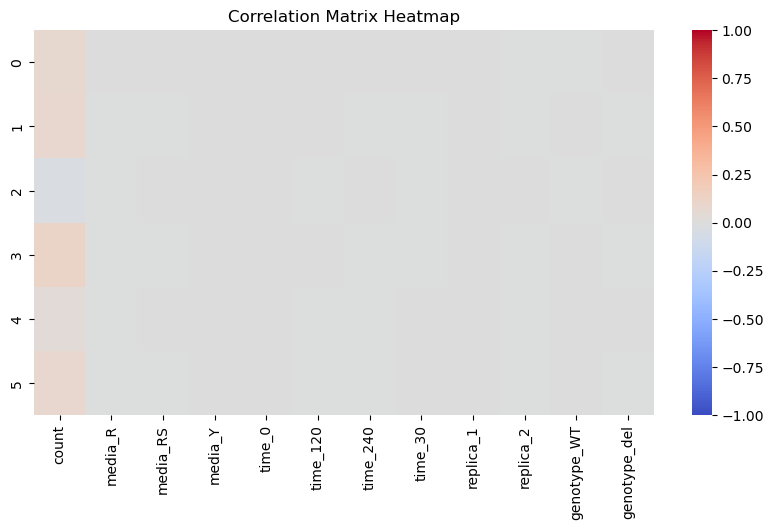

In [687]:
k = 2
viz_heatmap_pca(m_pca_all[k], x_pca_all[k], 0.8, k)

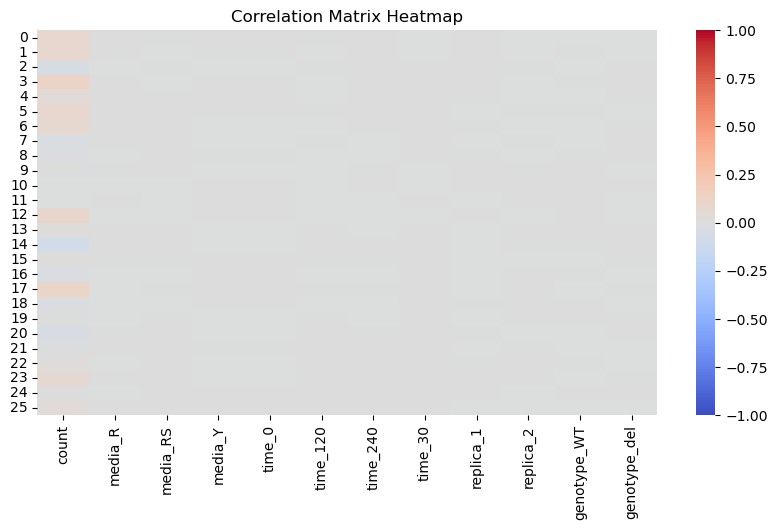

In [688]:
k = 3
viz_heatmap_pca(m_pca_all[k], x_pca_all[k], 0.8, k)

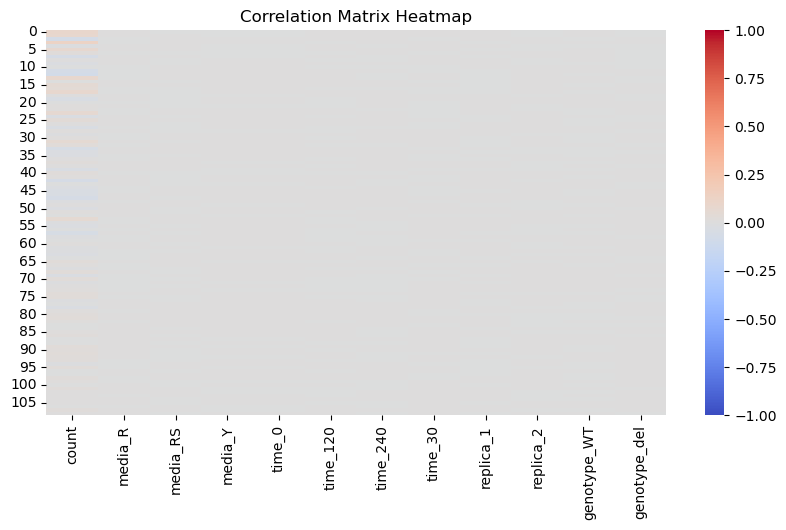

In [689]:
k = 4
viz_heatmap_pca(m_pca_all[k], x_pca_all[k], 0.8, k)

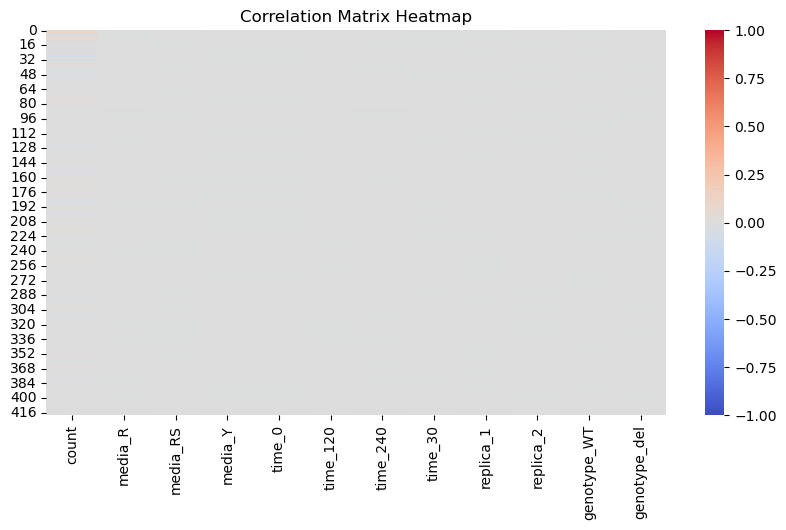

In [690]:
k = 5
viz_heatmap_pca(m_pca_all[k], x_pca_all[k], 0.8, k)